# Convolutional Neural Network

In [1]:
# WARNING: EXPENSIVE COMPUTING IF RUN_CALCULATION = True
# Calculation has already been done and saved in FILEPATH file and are reloaded from the file in this notebook
RUN_CALCULATION = False
GRID_FILEPATH   = 'saved_grid_search_results/cnn_grid.npy'
MODEL_FILEPATH  = 'saved_best_models/cnn/cnn_model.ckpt'

In [2]:
# Import functions used in the different notebooks of the course project
%run Tools.ipynb

In [3]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

## Loading images

In [4]:
# Load the pixels dataset
_, pixels, labels, names = load_data()

# Rescale the pixel values
pixels = (pixels - 128) / 255

# Reshape the data
pixels = pixels.reshape(-1, 32, 32, 3)

# Check shapes
print('Pixels shape:', pixels.shape)
print('Labels shape:', labels.shape)

Pixels shape: (5000, 32, 32, 3)
Labels shape: (5000,)


## Splitting Training / Validation / Test Sets

In [5]:
# Split the full train/test sets (4000/1000 stratified split)
X_train, X_test, y_train, y_test = split_data_stratified(pixels, labels, test_size=1000)

# Split the train for grid search/validation sets (3200/800 stratified split)
X_train_grid, X_valid, y_train_grid, y_valid = split_data_stratified(X_train, y_train, test_size=800)

# Check shapes
print('Train (for grid search) shape:', X_train_grid.shape, y_train_grid.shape)
print('Valid shape:', X_valid.shape, y_valid.shape)
print('Test shape:', X_test.shape, y_test.shape)

Train (for grid search) shape: (3200, 32, 32, 3) (3200,)
Valid shape: (800, 32, 32, 3) (800,)
Test shape: (1000, 32, 32, 3) (1000,)


## Stratified Batch Generator

In [6]:
# Batch generator
def get_stratified_batches(features, target, batch_size):
    
    # number of classes
    n_classes = len(np.unique(target))
    
    # batch size to accomodate the number of classes and have nice stratified batches
    batch_size = (batch_size // n_classes)
    
    # indices for one class
    idx = np.arange(len(target) // n_classes)
    np.random.shuffle(idx)
    
    # take the same number of observations/target values from each class
    for i in range(0, len(target) // n_classes, batch_size):
        batch_idx = idx[i:i+batch_size]
        
        X_batch = []
        y_batch = []
        
        # for each classes, get the batch_idx observations and target values
        for k in np.unique(target):
            filter = (target == k)
            X_batch.append(features[filter][batch_idx])
            y_batch.append(target[filter][batch_idx])
        
        # aggregate all sub-batches
        yield np.concatenate(X_batch, axis=0), np.concatenate(y_batch, axis=0)

## CNN Graph

This graph is the result of many experimentations and tuning by grid search, one layer at a time:
1. Tuning the first CNN layer (kernel, filters, strides) with no hidden fcnn layer
2. Tuning the second CNN layer (kernel, filters, strides) with the first selected CNN layer and again no hidden fcnn layer
3. Tuning the first FCNN layer (units, dropout rates) with both selected CNN layers 
4. Tuning the second FCNN layer (units, dropout rate) with all the previously selected layers
5. Tuning learning rate

It is not really interesting to presents all these results here and this process is probably a naive approach of how to well design a convolutional neuronal network and for sure, very time consuming. Overall it will give us good results but I tend to think it could be as good or better with a lighter and more efficient network structure.

Here is the network, we will train:

* 1st CNN layer:  256 8x8 kernels with 2x2 strides | 2x2 max pooling with 2x2 strides
* 2nd CNN layer:  256 4x4 kernels with 1x1 strides | 2x2 max pooling with 2x2 strides
* 0.7 dropout rate on the 4096 CNN output neurons
* 1st Hidden FCNN layer: 1024 units
* 0.7 dropout rate on the 1st FCNN layer 1024 units
* 2nd Hidden FCNN layer: 256 units
* 0.3 dropout rate in the 2nd FCNN layer 256 units
* Output layer: 4 units

We will train the model with a learning rate of $10^{-4}$

In [7]:
 # Create Graph
graph = tf.Graph()
with graph.as_default():
    
    # placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3], name='X')
    y = tf.placeholder(dtype=tf.int32, shape=[None], name='Y')
    lr = tf.placeholder(dtype=tf.float32, shape=[], name='LR')
    training = tf.placeholder(dtype=tf.bool, shape=[], name='Training')
    
    
    # CNN LAYER 1 + POOL
    conv1 = tf.layers.conv2d(
        X, 
        filters=256,            
        kernel_size=(8, 8),    
        strides=(2, 2),        
        padding='SAME',        
        activation=tf.nn.relu, 
        kernel_initializer=tf.truncated_normal_initializer(stddev=0.01, seed=0), 
        name='conv1' 
    )
    print('conv1:', conv1.shape)
        
    pool1 = tf.layers.max_pooling2d(
        conv1, 
        pool_size=(2, 2), 
        strides=(2, 2), 
        padding='SAME' 
    )
    print('pool1:', pool1.shape)
        
        
    # CNN LAYER 2 + POOL
    conv2 = tf.layers.conv2d(
        pool1, 
        filters=256,            
        kernel_size=(4, 4),    
        strides=(1, 1),        
        padding='SAME',        
        activation=tf.nn.relu, 
        kernel_initializer=tf.truncated_normal_initializer(stddev=0.01, seed=0), 
        name='conv2' 
    )
    print('conv2:', conv2.shape)
        
    pool2 = tf.layers.max_pooling2d(
        conv2, 
        pool_size=(2, 2), 
        strides=(2, 2), 
        padding='SAME' 
    )
    print('pool2:', pool2.shape)
       
    # -----------------------------
    
    # FCNN INPUT LAYER + DROPOUT
    flat_output = tf.contrib.layers.flatten(pool2)
    print('flat_output:', flat_output.shape)
        
    flat_output = tf.layers.dropout(
        flat_output, 
        rate=0.7, 
        seed=0,
        training=training
    )
    
    
    # FCNN HIDDEN LAYER 1 + DROPOUT 
    hidden = tf.layers.dense(
        flat_output, 
        1024, 
        activation=tf.nn.relu,
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='hidden'
    )
        
    hidden = tf.layers.dropout(
        hidden, 
        rate=0.7, 
        seed=0,
        training=training
    )
     
        
    # FCNN HIDDEN LAYER 2 + DROPOUT 
    hidden2 = tf.layers.dense(
        hidden, 
        256, 
        activation=tf.nn.relu,
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='hidden2'
    )
        
    hidden2 = tf.layers.dropout(
        hidden2, 
        rate=0.3, 
        seed=0,
        training=training
    )
    
    
    # OUTPUT LAYER
    logits = tf.layers.dense(
        hidden2, 
        4, 
        activation=None, 
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='output'
    )
    
    # -----
    
    # Kernel of the 1st conv. layer
    with tf.variable_scope('conv1', reuse=True):
        conv_kernels = tf.get_variable('kernel')
         
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))

    # Adam optimizer
    gd = tf.train.AdamOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32, name='Predictions')
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32), name='Accuracy')
    
    # Create a saver to save trained variables later
    saver = tf.train.Saver()

conv1: (?, 16, 16, 256)
pool1: (?, 8, 8, 256)
conv2: (?, 8, 8, 256)
pool2: (?, 4, 4, 256)
flat_output: (?, 4096)


## Network Tuning Result

The network has been tuned by using 3200 training images and 800 validation images and no cross validation because it would have been too much time consuming. This section presents only the results for the selected network. 

In the last part of this notebook, we will train the same network but with the full 4000 training images and evaluate its accuracy on the test set.

In [8]:
if RUN_CALCULATION | (os.path.exists(GRID_FILEPATH) == False):
    
    # Validation accuracy
    train_acc_values = []
    valid_acc_values = []

    with tf.Session(graph=graph) as sess:
        
        # Initialize variables
        sess.run(tf.global_variables_initializer())

        # Set seed
        np.random.seed(0)

        # Train several epochs
        for epoch in range(600):
        
            if (epoch % 25) == 0: 
                print('{} | epoch {}'.format(datetime.datetime.now().time(), epoch))
        
            # Accuracy values (train) after each batch
            batch_acc = []

            for X_batch, y_batch in get_stratified_batches(X_train_grid, y_train_grid, 64):
                # Run training and evaluate accuracy
                _, acc_value = sess.run([train_op, accuracy], feed_dict={
                    X: X_batch,
                    y: y_batch,
                    lr: 0.0001, # Learning rate
                    training: True
                })

                # Save accuracy (current batch)
                batch_acc.append(acc_value)
            
            # Training accuracy
            train_acc = np.mean(batch_acc)
            train_acc_values.append(train_acc)
            
            # Evaluate validation accuracy
            valid_acc = sess.run(accuracy, feed_dict={
                X: X_valid,
                y: y_valid,
                training: False
            })
            valid_acc_values.append(valid_acc)

        # Save results in a numpy file
        scores = {
            'train_acc_values': train_acc_values,
            'valid_acc_values': valid_acc_values
        }
        np.save(GRID_FILEPATH, scores)
else:
    # Load the grid scores results from file
    scores = np.load(GRID_FILEPATH, allow_pickle=True).item(0)

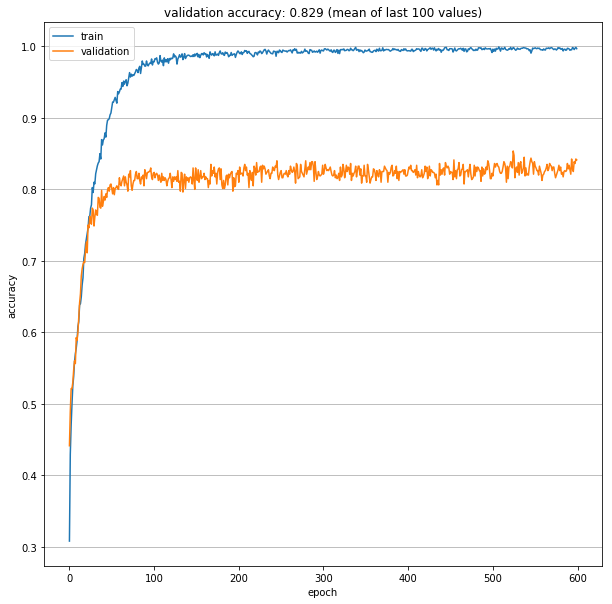

In [9]:
# Plot the training and validation accuracy curves
plt.figure(figsize=(10, 10))
plt.plot(scores['train_acc_values'], label='train')
plt.plot(scores['valid_acc_values'], label='validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(axis='y')
plt.title('validation accuracy: {:.3f} (mean of last 100 values)'.format(np.mean(scores['valid_acc_values'][-100:])))
plt.legend()
plt.show()

Despite the apparent overfitting, the validation accuracy tends to grow slowly, more epoch could be even better but 600 epoch correspond already to 6 hours of computation on my macbook pro. So, we will train the final model on the full train set with exactly the same network and hyperparameters... 

## Final Model Training & Test Accuracy

Here we train again the same network but on the full training data set (4000 images):

In [10]:
if RUN_CALCULATION | (os.path.exists(MODEL_FILEPATH + '.index') == False):
    
    with tf.Session(graph=graph) as sess:
        
        # Initialize variables
        sess.run(tf.global_variables_initializer())

        # Set seed
        np.random.seed(0)

        # Train several epochs
        for epoch in range(600):
        
            if (epoch % 25) == 0: 
                print('{} | epoch {}'.format(datetime.datetime.now().time(), epoch))
        
            for X_batch, y_batch in get_stratified_batches(X_train, y_train, 64):
                # Training
                _ = sess.run([train_op], feed_dict={
                    X: X_batch,
                    y: y_batch,
                    lr: 0.0001, # Learning rate
                    training: True # Apply dropouts
                })
       
        # Evaluate test accuracy
        test_acc = sess.run(accuracy, feed_dict={
            X: X_test,
            y: y_test,
            training: False
        })
        
        # Get 1st conv. layer kernels
        kernels = conv_kernels.eval()
        
        # Save training
        saver.save(sess, MODEL_FILEPATH)
else:
    # Load the network from file
    with tf.Session(graph=graph) as sess:
        # load trained variables
        saver.restore(sess, MODEL_FILEPATH)
    
        # evaluate test accuracy
        test_acc = sess.run(accuracy, feed_dict={
            X: X_test,
            y: y_test,
            training: False
        })
        
        # get 1st conv. layer kernels
        kernels = conv_kernels.eval()

INFO:tensorflow:Restoring parameters from saved_best_models/cnn/cnn_model.ckpt


In [11]:
print('Multilayer convolutional network accuracy (test set): {:.3f}'.format(test_acc))

Multilayer convolutional network accuracy (test set): 0.834


It's a nice result, better than some models using the overfeat data and similar to our multilayer fully-connected network (test accuracy of 0.838). It seems that the convolutional part of our network did a good job to extract patterns from the images.

Let's look at the first convolutional layer kernels.

## Visualizazion of the first convolutional layer kernels

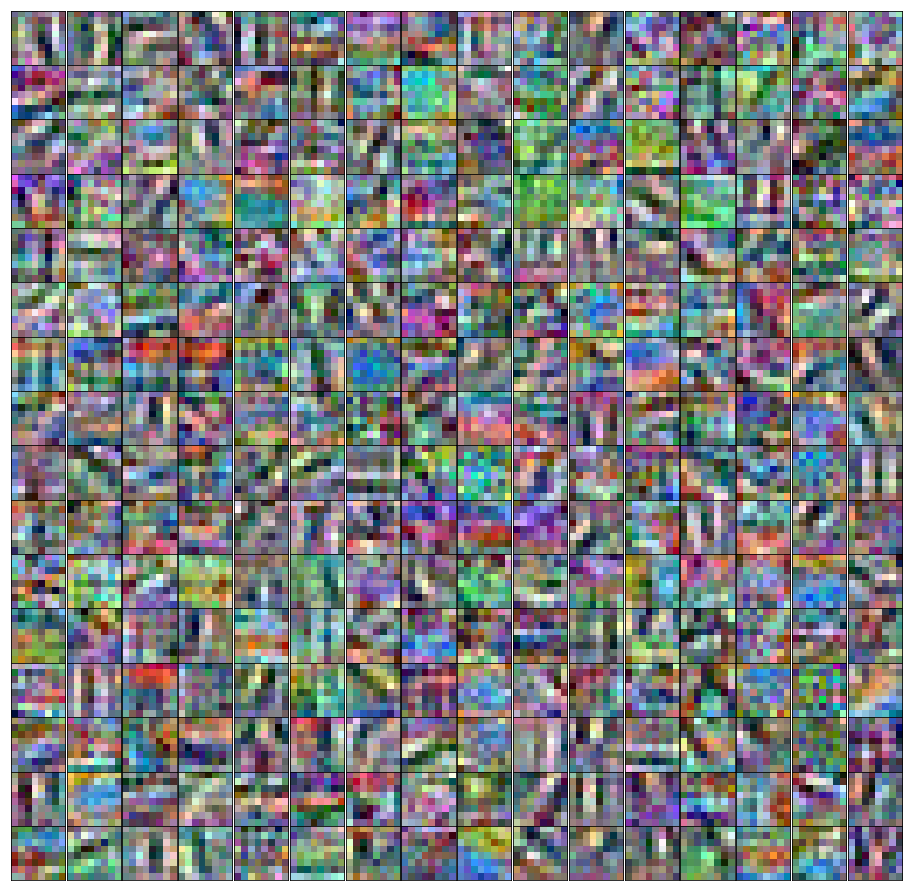

In [12]:
# Create a grid of subplots (256 images)
fig, axes = plt.subplots(nrows=16, ncols=16, figsize=(16, 16))

# Remove gaps between suplots
plt.subplots_adjust(wspace=0, hspace=0)

# Plot the 256 kernels from the first convolutional layer
for i, axis in enumerate(axes.flatten()):
    # Get i-th kernel (shape: 8x8x3)
    kernel = kernels[:, :, :, i].copy()
    
    # Rescale values between 0 and 1
    kernel -= kernel.min() # Rescale between 0 and max
    kernel /= kernel.max() # Rescale between 0 and 1
    
    # Plot kernel with imshow()
    axis.imshow(kernel)
    axis.get_xaxis().set_visible(False) # disable x-axis
    axis.get_yaxis().set_visible(False) # disable y-axis
    
plt.show()

Kernels looks nice but a little bit noisy, slower learning rate and maybe better dropout tuning could reduce overfitting and noise at the expense of more computation time.

Some kernels looks for shape patterns and other for background and color patterns. We can notice that some kernels are really yellow/green and other one blue/purple probably good to split the cars/trucks from the airplane/ships.